In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
import numpy as np
import os

In [2]:
IMAGE_SHAPE = (128, 128, 3)
CLASS_ONE = "Mundo3"

TRAIN_DATA_FILES = ["./DataNous/Caso_Dificil/Entrenamiento/Mundo3/*.png", "./DataNous/Caso_Dificil/Entrenamiento/Mundo6/*.png"]
VALIDATION_DATA_FILES = ["./DataNous/Caso_Dificil/Validacion/Mundo3/*.png", "./DataNous/Caso_Dificil/Validacion/Mundo6/*.png"]

CHECKPOINTS = "./DataNous/Caso_Dificil/Checkpoints/Caso_Dificil_{epoch:04d}.h5"

BATCH_SIZE = 32

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), strides=(2,2), padding='same', input_shape=IMAGE_SHAPE))
model.add(tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), padding='same'))
model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16385     
Total params: 39,969
Trainable params: 39,969
Non-trainable params: 0
_________________________________________________________________


In [4]:
def process_dataset(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    label = label == CLASS_ONE
    label = tf.cast(label, dtype=tf.float32)

    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image)
    image = tf.image.resize(image, (128, 128))
    image = (tf.image.convert_image_dtype(image, tf.float32) / 127.5) - 1

    return image, label

In [5]:
train_dataset = tf.data.Dataset.list_files(TRAIN_DATA_FILES)
train_dataset = train_dataset.map(process_dataset, tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.list_files(VALIDATION_DATA_FILES)
validation_dataset = validation_dataset.map(process_dataset, tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
Optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
Loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=Optimizer,
               loss=Loss,
               metrics=['binary_accuracy'])

checkpoints = tf.keras.callbacks.ModelCheckpoint(CHECKPOINTS,
                                                 save_best_only=True,
                                                 monitor='binary_accuracy')

In [7]:
initial_epochs = 20
num_batches = np.ceil(len(list(tf.data.Dataset.list_files(TRAIN_DATA_FILES))) / BATCH_SIZE)
num_batches

339.0

In [8]:
history = model.fit(x=train_dataset,
                       shuffle=True,
                       #verbose=2,
                       callbacks=[checkpoints], #, TensorBoard],
                       steps_per_epoch=num_batches,
                       epochs=initial_epochs,
                       validation_data=validation_dataset,
                       initial_epoch=0)

Train for 339.0 steps, validate for 38 steps
Epoch 1/20
339/339 [==============================] - 95s 279ms/step - loss: 0.7294 - binary_accuracy: 0.5745 - val_loss: 0.6391 - val_binary_accuracy: 0.6420
Epoch 2/20
339/339 [==============================] - 85s 251ms/step - loss: 0.5590 - binary_accuracy: 0.7166 - val_loss: 0.5072 - val_binary_accuracy: 0.7716
Epoch 3/20
339/339 [==============================] - 96s 284ms/step - loss: 0.4428 - binary_accuracy: 0.8305 - val_loss: 0.3963 - val_binary_accuracy: 0.8580
Epoch 4/20
339/339 [==============================] - 88s 261ms/step - loss: 0.3394 - binary_accuracy: 0.9000 - val_loss: 0.3038 - val_binary_accuracy: 0.9128
Epoch 5/20
339/339 [==============================] - 84s 249ms/step - loss: 0.2567 - binary_accuracy: 0.9331 - val_loss: 0.2284 - val_binary_accuracy: 0.9402
Epoch 6/20
339/339 [==============================] - 85s 250ms/step - loss: 0.1913 - binary_accuracy: 0.9534 - val_loss: 0.1734 - val_binary_accuracy: 0.9551
E

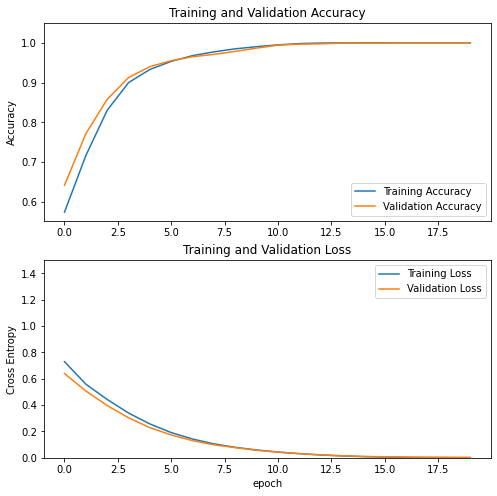

In [11]:
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.05])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()